In [6]:
%matplotlib inline
from pyiem.util import get_dbconn
from pandas.io.sql import read_sql
asos_pgconn = get_dbconn('asos', user='nobody')
acursor = asos_pgconn.cursor()

today = read_sql("""SELECT date(valid ) as date,
  extract(hour  from valid + '10 minutes'::interval) as hr
  , min(round(tmpf::numeric,0)) as tmpf from alldata
  where station = 'DSM' and valid > '2017-11-08 23:50' 
  and valid < '2017-11-09 23:00' and tmpf is not null
  GROUP by date, hr ORDER by date, hr ASC
  """, asos_pgconn, index_col='hr')
today['last_date'] = None
today['last_tmpf'] = None
today['last_low'] = None
print(today)

            date  tmpf last_date last_tmpf last_low
hr                                                 
0.0   2017-11-08  36.0      None      None     None
1.0   2017-11-09  40.0      None      None     None
2.0   2017-11-09  40.0      None      None     None
3.0   2017-11-09  41.0      None      None     None
4.0   2017-11-09  40.0      None      None     None
5.0   2017-11-09  36.0      None      None     None
6.0   2017-11-09  33.0      None      None     None
7.0   2017-11-09  31.0      None      None     None
8.0   2017-11-09  30.0      None      None     None
9.0   2017-11-09  30.0      None      None     None
10.0  2017-11-09  30.0      None      None     None
11.0  2017-11-09  31.0      None      None     None
12.0  2017-11-09  32.0      None      None     None
13.0  2017-11-09  33.0      None      None     None
14.0  2017-11-09  34.0      None      None     None
15.0  2017-11-09  33.0      None      None     None
16.0  2017-11-09  30.0      None      None     None
17.0  2017-1

In [2]:
import mx.DateTime
thursdays =[]
for yr in range(1880,2015):
  nov1 = mx.DateTime.DateTime(yr, 2, 14)
  turkey = nov1
  #turkey = nov1 + mx.DateTime.RelativeDateTime(weekday=(mx.DateTime.Thursday,4))
  thursdays.append(turkey.strftime("%Y-%m-%d"))

In [7]:
COOP = get_dbconn('coop', user='nobody')
ccursor = COOP.cursor()
dates = []
highs = []
for hr, row in today.iterrows():
    print("Processing hour: %s" % (hr, ))
    acursor.execute("""
    SELECT valid, tmpf from alldata WHERE 
    extract(hour from valid + '10 minutes') = %s and station = 'DSM' 
    and round(tmpf::numeric, 0) <= %s
    and valid < %s and extract(month from valid) = 11 and
    extract(day from valid) < 10
    ORDER by valid DESC LIMIT 1
    """, (hr, row['tmpf'], row['date']))
    row = acursor.fetchone()
    if row is not None:
        today.at[hr, 'last_tmpf'] = row[1]
        today.at[hr, 'last_date'] = row[0]
    
        ccursor.execute("""
        SELECT low from alldata_ia where station = 'IA2203'
        and day = %s""", (row[0].strftime("%Y-%m-%d"),))
        row2 = ccursor.fetchone()
        today.at[hr, 'last_low'] = row2[0]

print(today)

Processing hour: 0.0
Processing hour: 1.0
Processing hour: 2.0
Processing hour: 3.0
Processing hour: 4.0
Processing hour: 5.0
Processing hour: 6.0
Processing hour: 7.0
Processing hour: 8.0
Processing hour: 9.0
Processing hour: 10.0
Processing hour: 11.0
Processing hour: 12.0
Processing hour: 13.0
Processing hour: 14.0
Processing hour: 15.0
Processing hour: 16.0
Processing hour: 17.0
Processing hour: 18.0
Processing hour: 19.0
Processing hour: 20.0
Processing hour: 21.0
Processing hour: 22.0
Processing hour: 23.0
            date  tmpf                  last_date last_tmpf last_low
hr                                                                  
0.0   2017-11-08  36.0  2017-11-07 23:54:00-06:00      28.9       29
1.0   2017-11-09  40.0  2017-11-08 00:54:00-06:00        27       22
2.0   2017-11-09  40.0  2017-11-08 01:54:00-06:00        27       22
3.0   2017-11-09  41.0  2017-11-08 02:54:00-06:00        27       22
4.0   2017-11-09  40.0  2017-11-08 03:54:00-06:00        25       22

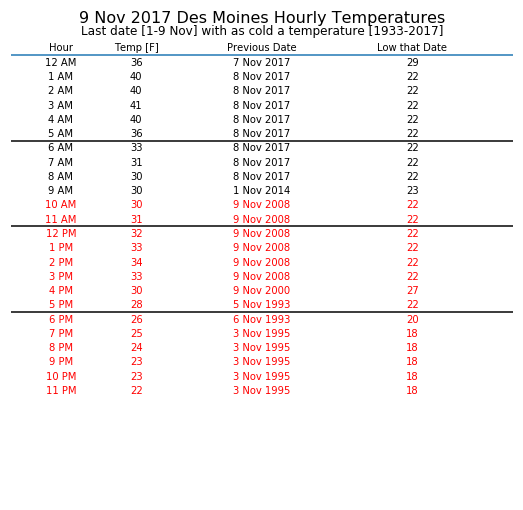

In [10]:
import datetime
import matplotlib.pyplot as plt

(fig, ax) = plt.subplots(1,1, figsize=(9,9))

ax.text(0.5, 0.97, '9 Nov 2017 Des Moines Hourly Temperatures', ha='center', size=16)
ax.text(0.5, 0.94, 'Last date [1-9 Nov] with as cold a temperature [1933-2017]',
        ha='center', size=12)

ax.text(0.1, 0.90, 'Hour', ha='center')
ax.text(0.25, 0.90, 'Temp [F]', ha='center')
ax.text(0.5, 0.90, 'Previous Date', ha='center')
ax.text(0.8, 0.90, 'Low that Date', ha='center')

ax.plot([0.,1.], [0.89,0.89])

y = 0.865
for hr, row in today.iterrows():
    ts = datetime.datetime(2000,1,1, int(hr))
    color = 'k' if row['last_date'].year > 2008 else 'r'
    ax.text(0.1, y, "%s" % (ts.strftime("%-I %p"),), ha='center', color=color)
    ax.text(0.25, y, "%.0f" % (row['tmpf'],), ha='center', color=color)
    ax.text(0.5, y, "%s" % (row['last_date'].strftime("%-d %b %Y"),), ha='center', color=color)
    ax.text(0.8, y, "%s" % (row['last_low'],), ha='center', color=color)
    if hr in (5,11,17):
        ax.plot([0,1], [y-0.01,y-0.01], color='k')
    y -= 0.035

ax.set_ylim(-0.2,1)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_xlim(0,1)
ax.axis('off')
    
fig.savefig('test.png')
